# Y2K references classification

### Imports

In [138]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

import torch
import torchvision
import torchvision.transforms.v2 as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, default_collate

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


### Functions for plot results

In [2]:
def evaluate_model(y_true, y_pred, title, average='macro'):
    print(f"\n{title}")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, average=average), 4))
    print("Recall   :", round(recall_score(y_true, y_pred, average=average), 4))
    print("F1-score :", round(f1_score(y_true, y_pred, average=average), 4))
    print("\nОтчёт по классам:\n", classification_report(y_true, y_pred))


In [3]:
def plot_confusion_matrix(y_true, y_pred, title):
    class_names = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', 
        xticklabels=class_names, yticklabels=class_names 
    )
    
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title(f'Матрица ошибок {title}')
    plt.show()


In [4]:
def plot_training_history(train_accuracies, valid_accuracies, 
                         train_losses, valid_losses, num_epochs,
                         title="Training History"):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title, fontsize=16)
    
    epochs_range = range(1, num_epochs + 1)
    
    ax1 = axes[0]
    ax1.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    ax1.plot(epochs_range, valid_accuracies, label="Valid Accuracy", marker='s')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training vs Validation Accuracy")
    ax1.legend()
    
    ax2 = axes[1]
    ax2.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    ax2.plot(epochs_range, valid_losses, label="Valid Loss", marker='s')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training vs Validation Loss")
    ax2.legend()
    
    plt.show()


In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.Figure(figsize=(12,10))


In [204]:
def plot_imgs_predict(imgs, y_pred, y_true, conf, title=None):
    n = len(imgs)
    cols = 5
    rows = math.ceil(n / cols)

    plt.figure(figsize=(15, 3 * rows))

    if title is not None:
        plt.suptitle(title, fontsize=16)
    
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        subplt_title = 'predicted: ' + y_pred[i] + '\n confidence:' + str(round(conf[i], 2)) + '\n actual:' + y_true[i]
        imshow(torch.Tensor(imgs[i]), title=subplt_title)

    
    plt.tight_layout()
    plt.show()

### Setting up device

In [5]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

Using device: mps


## Load Data

In [6]:
data_path = '/Users/albertzagibin/Documents/Стартап/Тестовое/data'

Зададим аугментацию для обучающей и тестовой выборки

In [7]:
NUM_CLASSES = 2

In [33]:
train_transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.RandomResizedCrop(size=(224, 224), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize(232),
    T.CenterCrop(size=(224, 224)),  
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [236]:
train_dataset = torchvision.datasets.ImageFolder(
    root='/Users/albertzagibin/Documents/Стартап/Тестовое/data/train', 
    transform=train_transforms
)

valid_dataset = torchvision.datasets.ImageFolder(
    root='/Users/albertzagibin/Documents/Стартап/Тестовое/data/valid', 
    transform=test_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root='/Users/albertzagibin/Documents/Стартап/Тестовое/data/test', 
    transform=test_transforms
)


In [283]:
cutmix_alpha=0.9
mixup_alpha = 0.2

cutmix = T.CutMix(alpha=cutmix_alpha, num_classes=NUM_CLASSES)
mixup = T.MixUp(alpha=mixup_alpha, num_classes=NUM_CLASSES)
cutmix_or_mixup = T.RandomChoice([cutmix, mixup])

In [284]:
def collate_fn(batch):
    return mixup(*default_collate(batch))

In [311]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    # collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=2, 
    shuffle=False, 
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=2, 
    shuffle=False, 
)

Примеры, что мы подаем на вход нейронки

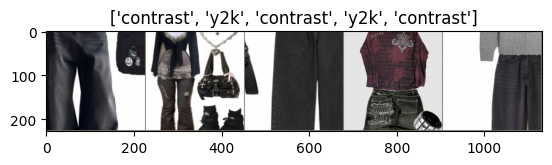

In [314]:
inputs, classes = next(iter(train_loader))

if classes.ndim >= 2:
    classes = classes.argmax(dim=1)

class_names = train_dataset.classes

out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes][:5])

## ResNet18 from scratch

In [56]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(
            self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, 
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(
            intermediate_channels, intermediate_channels, 
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
        
    def forward(self, x): 
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x 


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, p=0.5, num_classes=2):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(BasicBlock, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(BasicBlock, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(BasicBlock, layers[3], intermediate_channels=512, stride=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.d = nn.Dropout(p=p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)   
        

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * block.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * block.expansion),
            )
        
        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * block.expansion
        for _ in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)  
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.d(x)
        x = self.fc(x)

        return x


In [57]:
def ResNet18(p=0.5, img_channel=3, num_classes=2):
    return ResNet(BasicBlock,[2,2,2,2],img_channel, p=p ,num_classes=num_classes)

### Train model functions

In [234]:
def evaluate_nn_model(model, loader, device):
    model.eval()
    all_confidence = []
    all_predictions = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            probs = F.softmax(output, dim=1)
            confidence, predicted = torch.max(probs, 1)

            if labels.ndim >= 2:
                labels = labels.argmax(dim=1)

            all_confidence.extend(confidence.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())

    all_images = np.array(all_images)

    return all_confidence, all_predictions, all_labels, all_images

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        _pred = model(images)
        loss = criterion(_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            pred = model(images)
            loss = criterion(pred, labels)

            total_loss += loss.item()

            # Чтобы могли считать Acc на трейне, но здесь это сделано только для визуализации
            if labels.ndim >= 2:
                labels = labels.argmax(dim=1)

            _, preds = torch.max(pred, 1) #pred.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, device, num_epochs = 10):
    best_model_state = None
    best_valid_loss = float("inf")

    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        _, train_acc = evaluate(model, train_loader, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

        scheduler.step()

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()
    print(f'Best Valid Loss {best_valid_loss}')

    return model, train_accuracies, valid_accuracies, train_losses, valid_losses

In [59]:
model = ResNet18(p=0.4, img_channel=3, num_classes=2).to(device)
y = model(torch.randn(4, 3, 224, 224).to(device)).to(device)
assert y.size() == torch.Size([4, 2])
print(y.size())

torch.Size([4, 2])


## Подбор гипперпараметра p - вероятность Дропаута

In [61]:
results = {}
num_trials = 20
p_values = [round(random.uniform(0.2, 0.5), 2) for _ in range(num_trials)]
num_epochs = 30

for p in p_values:
    print(f"\n=== Training with dropout p={p} ===")
    
    model = ResNet18(p=p, img_channel=3, num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

    best_val_acc = 0.0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

        scheduler.step()
        best_val_acc = max(best_val_acc, valid_acc)

    results[p] = best_val_acc



=== Training with dropout p=0.26 ===

=== Training with dropout p=0.38 ===

=== Training with dropout p=0.4 ===

=== Training with dropout p=0.41 ===

=== Training with dropout p=0.32 ===

=== Training with dropout p=0.36 ===

=== Training with dropout p=0.35 ===

=== Training with dropout p=0.2 ===

=== Training with dropout p=0.39 ===

=== Training with dropout p=0.48 ===

=== Training with dropout p=0.44 ===

=== Training with dropout p=0.22 ===

=== Training with dropout p=0.28 ===

=== Training with dropout p=0.28 ===

=== Training with dropout p=0.28 ===

=== Training with dropout p=0.3 ===

=== Training with dropout p=0.32 ===

=== Training with dropout p=0.23 ===

=== Training with dropout p=0.44 ===

=== Training with dropout p=0.21 ===


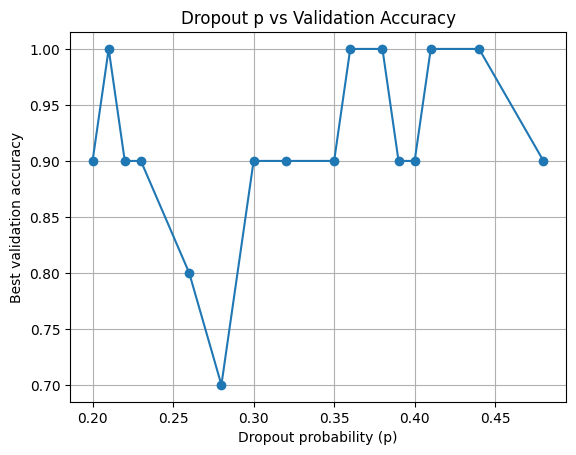

In [62]:
p_acc = sorted(results.items())

p = [x[0] for x in p_acc]
acc = [x[1] for x in p_acc]

plt.figure()
plt.plot(p, acc, marker='o')
plt.xlabel('Dropout probability (p)')
plt.ylabel('Best validation accuracy')
plt.title('Dropout p vs Validation Accuracy')
plt.grid(True)
plt.show()

## Train ResNet18

In [315]:
model = ResNet18(p=0.38, img_channel=3, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

num_epochs = 30
model, train_accuracies, valid_accuracies, train_losses, valid_losses = train_model(model, criterion, optimizer, scheduler, 
                                                                                    train_loader, valid_loader,
                                                                                    device, num_epochs)

Epoch 1/30
Train Loss: 0.5919
Valid Loss: 0.8655 | Valid Acc: 0.5000
Epoch 2/30
Train Loss: 0.4850
Valid Loss: 1.9350 | Valid Acc: 0.5000
Epoch 3/30
Train Loss: 0.9182
Valid Loss: 1.9029 | Valid Acc: 0.5000
Epoch 4/30
Train Loss: 0.5185
Valid Loss: 0.9003 | Valid Acc: 0.6000
Epoch 5/30
Train Loss: 0.3772
Valid Loss: 0.5706 | Valid Acc: 0.8000
Epoch 6/30
Train Loss: 0.4264
Valid Loss: 0.5980 | Valid Acc: 0.7000
Epoch 7/30
Train Loss: 0.3575
Valid Loss: 0.6031 | Valid Acc: 0.7000
Epoch 8/30
Train Loss: 0.5042
Valid Loss: 0.4653 | Valid Acc: 0.8000
Epoch 9/30
Train Loss: 0.3657
Valid Loss: 0.4540 | Valid Acc: 0.8000
Epoch 10/30
Train Loss: 0.3706
Valid Loss: 0.6728 | Valid Acc: 0.6000
Epoch 11/30
Train Loss: 0.3247
Valid Loss: 0.7993 | Valid Acc: 0.6000
Epoch 12/30
Train Loss: 0.4729
Valid Loss: 0.9988 | Valid Acc: 0.6000
Epoch 13/30
Train Loss: 0.3875
Valid Loss: 1.5364 | Valid Acc: 0.5000
Epoch 14/30
Train Loss: 0.2555
Valid Loss: 1.0104 | Valid Acc: 0.6000
Epoch 15/30
Train Loss: 0.295

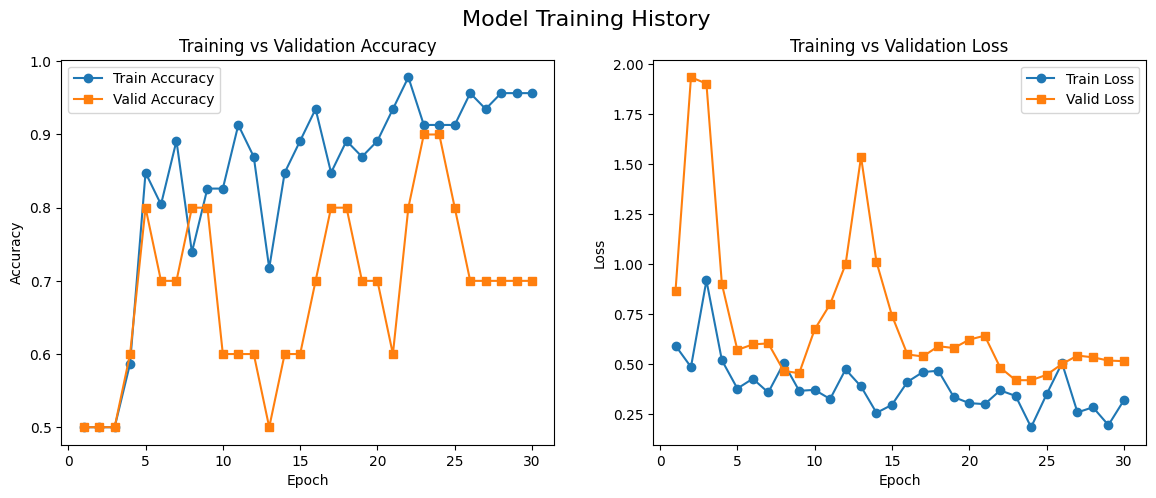

In [316]:
plot_training_history(
    train_accuracies, valid_accuracies, 
    train_losses, valid_losses, num_epochs,
    title="Model Training History"
)

In [321]:
PATH = '/Users/albertzagibin/Documents/Стартап/Тестовое/models/ResNet18_best.pth'

In [ ]:
# torch.save(model.state_dict(), PATH)

In [ ]:
# model = ResNet18(p=0.4, img_channel=3, num_classes=2).to(device)
# model.load_state_dict(torch.load(PATH))


Результаты Train 

Accuracy : 0.913
Precision: 0.913
Recall   : 0.9259
F1-score : 0.9124

Отчёт по классам:
               precision    recall  f1-score   support

    contrast       1.00      0.85      0.92        27
         y2k       0.83      1.00      0.90        19

    accuracy                           0.91        46
   macro avg       0.91      0.93      0.91        46
weighted avg       0.93      0.91      0.91        46



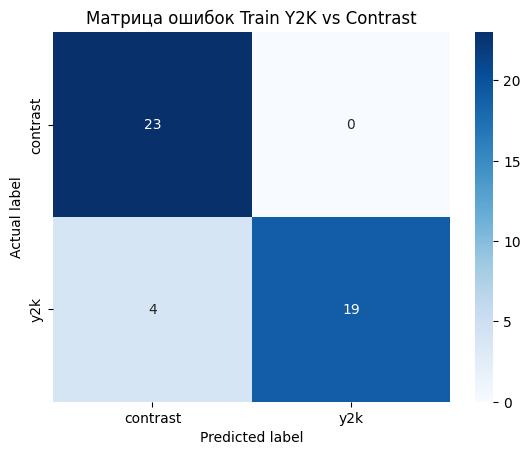

In [317]:
conf_tr, y_pred_tr, y_true_tr, imgs_tr = evaluate_nn_model(model, train_loader, device)
y_pred_tr = [class_names[x] for x in y_pred_tr]
y_true_tr = [class_names[x] for x in y_true_tr]


evaluate_model(y_pred_tr, y_true_tr, 'Результаты Train \n')
plot_confusion_matrix(y_true_tr, y_pred_tr, "Train Y2K vs Contrast")


Результаты Valid 

Accuracy : 0.9
Precision: 0.9
Recall   : 0.9167
F1-score : 0.899

Отчёт по классам:
               precision    recall  f1-score   support

    contrast       1.00      0.83      0.91         6
         y2k       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



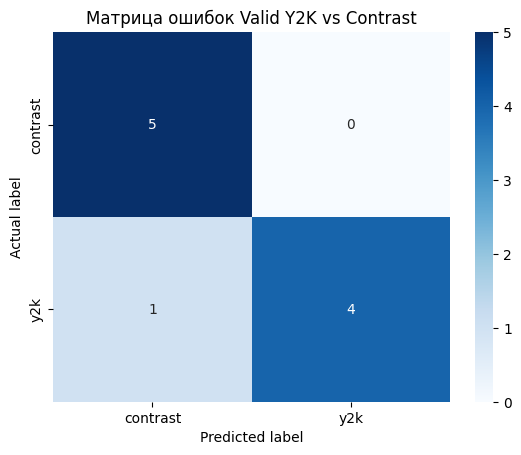


Результаты Test 

Accuracy : 0.8
Precision: 0.8
Recall   : 0.8571
F1-score : 0.7917

Отчёт по классам:
               precision    recall  f1-score   support

    contrast       1.00      0.71      0.83         7
         y2k       0.60      1.00      0.75         3

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



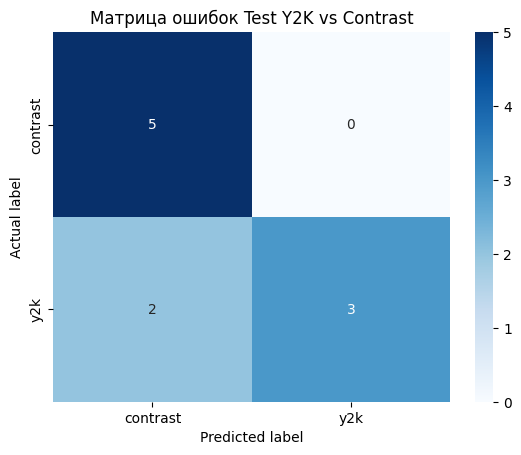

In [318]:
conf_v, y_pred_v, y_true_v, imgs_v = evaluate_nn_model(model, valid_loader, device)
y_pred_v = [class_names[x] for x in y_pred_v]
y_true_v = [class_names[x] for x in y_true_v]

conf_t, y_pred_t, y_true_t, imgs_t = evaluate_nn_model(model, test_loader, device)
y_pred_t = [class_names[x] for x in y_pred_t]
y_true_t = [class_names[x] for x in y_true_t]


evaluate_model(y_pred_v, y_true_v, 'Результаты Valid \n')
plot_confusion_matrix(y_true_v, y_pred_v, "Valid Y2K vs Contrast")

evaluate_model(y_pred_t, y_true_t, 'Результаты Test \n')
plot_confusion_matrix(y_true_t, y_pred_t, "Test Y2K vs Contrast")

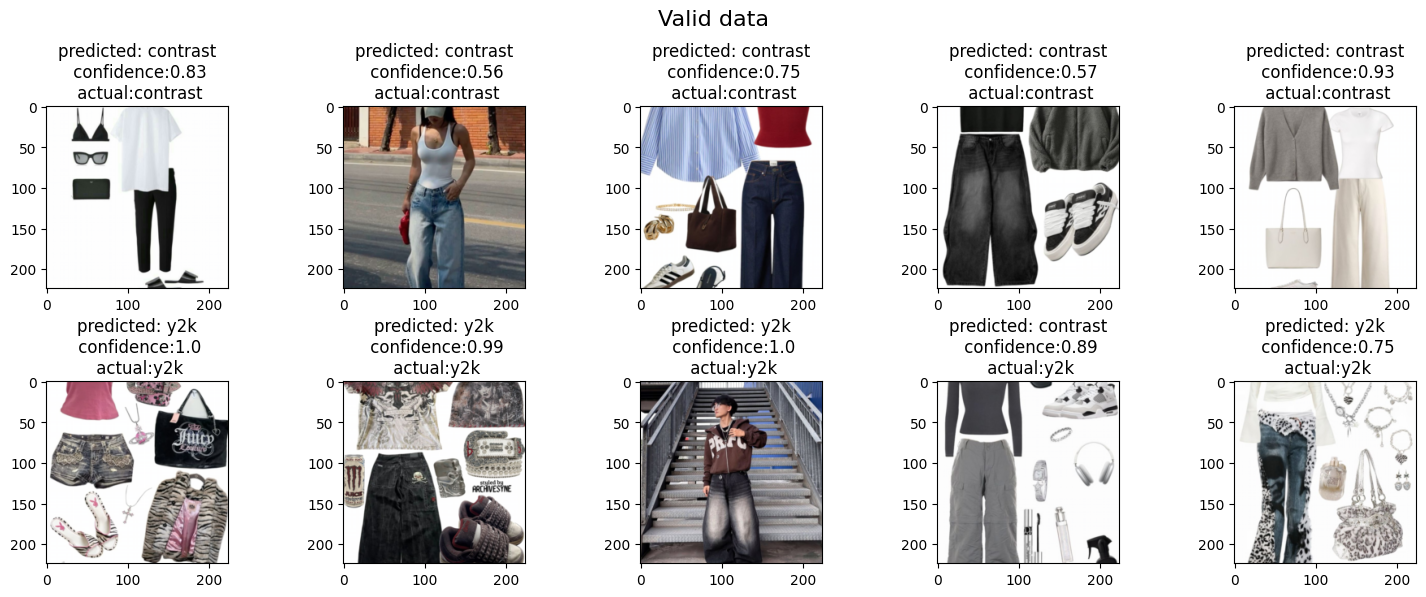

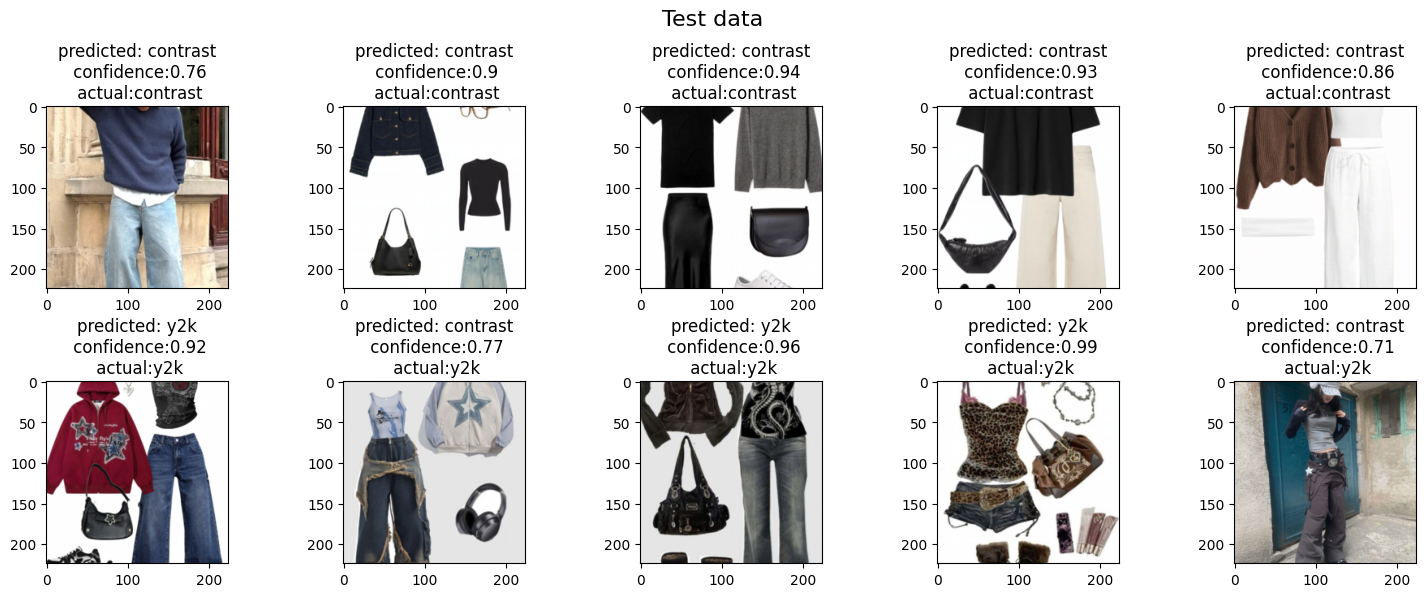

In [319]:
plot_imgs_predict(imgs_v, y_pred_v, y_true_v, conf_v, title='Valid data')

plot_imgs_predict(imgs_t, y_pred_t, y_true_t, conf_t, title='Test data')

In [320]:
mean_conf_v = np.mean(conf_v)
mean_conf_t = np.mean(conf_t)

print(f'Средняя уверенность в предсказании на Valid: {mean_conf_v:.2f}')
print(f'Средняя уверенность в предсказании на Test: {mean_conf_t:.2f}')

Средняя уверенность в предсказании на Valid: 0.83
Средняя уверенность в предсказании на Test: 0.87
